In [3]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import rotate, InterpolationMode
import torchvision.transforms.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt
print('pytorch version is ', torch.__version__)

pytorch version is  1.9.0


In [4]:
#####################
# helper function
#####################
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    plt.show()

In [5]:
#####################
# Import data
#####################

# Specify the file paths
sinogram_path = os.path.join(os.pardir, 'dataset_foam', 'x_train_sinograms.npy')
obj_path = os.path.join(os.pardir,'dataset_foam', 'foam_training.npy')

# Load the .npy files
sinogram_data = np.load(sinogram_path)
obj_data = np.load(obj_path)

# Convert the data to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sinogram_tensor = torch.from_numpy(sinogram_data).to(device)
obj_tensor = torch.from_numpy(obj_data).to(device)

# Check the tensor shapes
print("sinogram shape: ", sinogram_tensor.shape)
print("obj shape: ", obj_tensor.shape)
print("obj dtype: ", obj_tensor.dtype)

# Preprocess
image_batch = obj_tensor.unsqueeze(1) # Size = (n,y,x)
angles = np.arange(90, 270, dtype=float) # Angle list
print(f"device is {device}")
print(f"sinogram_tensor device is {sinogram_tensor.device}")
print(f"obj_tensor device is {obj_tensor.device}")
print(f"image_batch device is {image_batch.device}")


sinogram shape:  torch.Size([50, 180, 184])
obj shape:  torch.Size([50, 128, 128])
obj dtype:  torch.float64
device is cuda
sinogram_tensor device is cuda:0
obj_tensor device is cuda:0
image_batch device is cuda:0


In [6]:
class ImageRotator(nn.Module):
    def __init__(self):
        super(ImageRotator, self).__init__()
        
    def forward(self, image_batch, angles):
        # Check input shapes
        assert len(image_batch.shape) == 4, "Invalid image_batch shape. Expected (n, c, y, x)."
        assert len(angles.shape) == 1, "Invalid angles shape. Expected (k,)."

        n, c, y, x = image_batch.shape
        k = angles.shape[0]
        
        # Initialize a tensor to store the rotated images
        rotated_imgs = torch.zeros((n, k, y, x), device=image_batch.device)

        for i in range(n):
            image = image_batch[i]  # Get current image
            for j in range(k):
                image_rotated = F.rotate(image, -angles[j]) #, interpolation=InterpolationMode.BILINEAR)  # Rotate the image in the opposite direction
                rotated_imgs[i][j] = image_rotated
        self.rotated_batch = rotated_imgs

class ImgToSinogram(nn.Module):
    def __init__(self):
        super(ImgToSinogram, self).__init__()

    def forward(self, rotated_image_batch):
        # Check input shape
        assert len(rotated_image_batch.shape) == 4, "Invalid image_batch shape. Expected (n, k, y, x)."

        n, k, y, x = rotated_image_batch.shape

        # Initialize a tensor to store the sinograms
        #padding = 28
        #padding_tensor = torch.zeros(padding).to(image_batch.device)
        #sinograms = torch.zeros((n, k, x + 2 * padding), device=image_batch.device)
        sinograms = torch.zeros((n, k, 184), device=rotated_image_batch.device)

        for i in range(n):
            #sinogram = torch.zeros((k, x + 2 * padding), device=image_batch.device)
            sinogram = torch.zeros((k, 184), device=rotated_image_batch.device)
            #sum_vec = torch.ones((128, 1)).to(rotated_image_batch.device)
            for j in range(k):
                image = rotated_image_batch[i, j]  # Get current image
                line_integrated = torch.sum(image, dim=1)  # Line integration along the y-axis
                start = (sinogram.shape[0] - line_integrated.shape[0]) // 2
                # Assign p values to the ith row of the sinogram, centered
                sinogram[i,start:start+line_integrated.shape[0]] = line_integrated.reshape(-1)
                #line_integrated_padded = torch.cat((padding_tensor, line_integrated, padding_tensor))
                #sinogram[j] = line_integrated_padded
                '''
                # ith_p is the i-th row of the sinogram corresponding to each angle
                ith_p = torch.matmul(rotated_image_batch[i,j,:,:],sum_vec)/180
                start = (sinogram.shape[0] - ith_p.shape[0]) // 2
                # Assign p values to the ith row of the sinogram, centered
                sinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)
                '''
            sinograms[i] = sinogram

        self.sinogram_batch = sinograms

In [7]:
start_time = time.time()

# Create an instances for the class
rotata = ImageRotator()
sinooo = ImgToSinogram()

# Pass the image batch and angles through the model
rotata.forward(image_batch, angles)
sinooo.forward(rotata.rotated_batch)

rotated_images_batch = rotata.rotated_batch
sinogram_batch = sinooo.sinogram_batch

print(rotated_images_batch.shape)
print(sinogram_batch.shape)

elapsed_time = time.time() - start_time
print("Took ",elapsed_time," sec")

torch.Size([50, 180, 128, 128])
torch.Size([50, 180, 184])
Took  2.131373167037964  sec


torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([180, 184])
torch.Size([1, 128, 128])


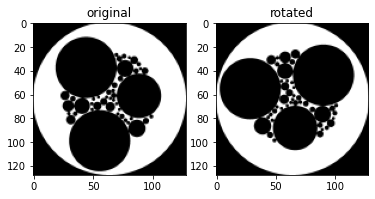

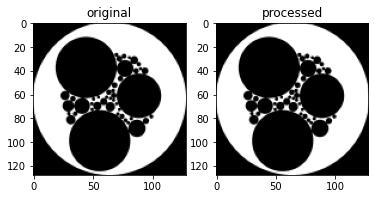

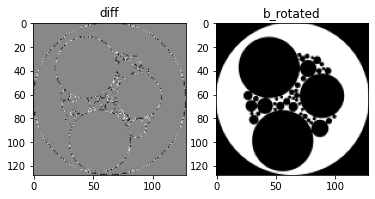

In [12]:
rotating_angle = 0
a = image_batch[0].squeeze()
b = rotated_images_batch[0][rotating_angle]
c = sinogram_batch[0]

print(a.shape)
print(b.shape)
print(c.shape)
b_rotated = rotate(b.unsqueeze(0), rotating_angle+90)
print(b_rotated.shape)

# plot_2_img_tensor(a,c,"original","sinogram")
plot_2_img_tensor(a,b,"original","rotated")
b_rotated = b_rotated.reshape(128,128)

plot_2_img_tensor(a,b_rotated,"original","processed")
plot_2_img_tensor(a-b_rotated,b_rotated,"diff","b_rotated")

In [9]:
# Specify the file path
sinogram_orininal_path = os.path.join(os.pardir, 'dataset_foam', 'x_train_sinograms.npy')
sinogram_original = np.load(sinogram_orininal_path)

obj = image_batch[:5]
my_sinogram = sinogram_batch[:5]
target_sinogram = sinogram_original[:5]

print(target_sinogram[0].shape)
print(sinogram_batch[0].shape)

(180, 184)
torch.Size([180, 184])


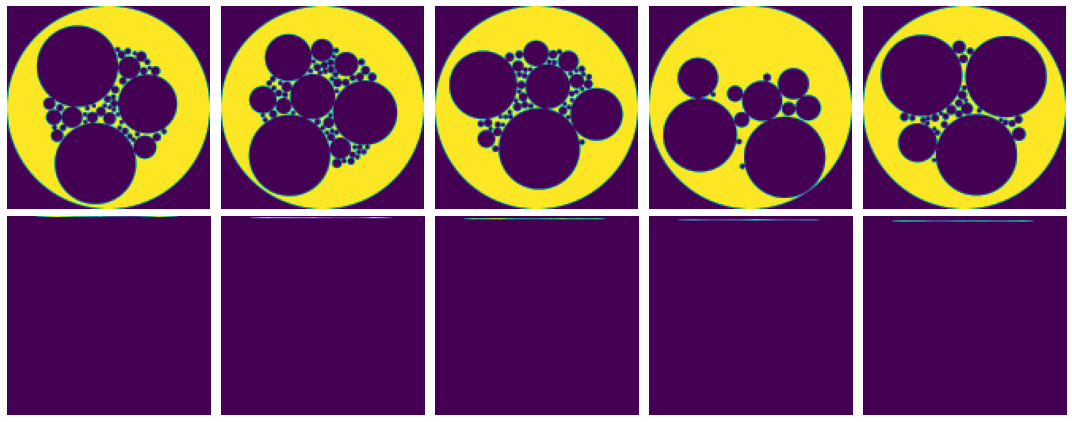

In [10]:
# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, obj in enumerate(obj):
    axes[0, i].imshow(obj.squeeze().cpu().numpy())
    axes[0, i].axis('off')

for i, sino in enumerate(my_sinogram):
    axes[1, i].imshow(sino.cpu().numpy())
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

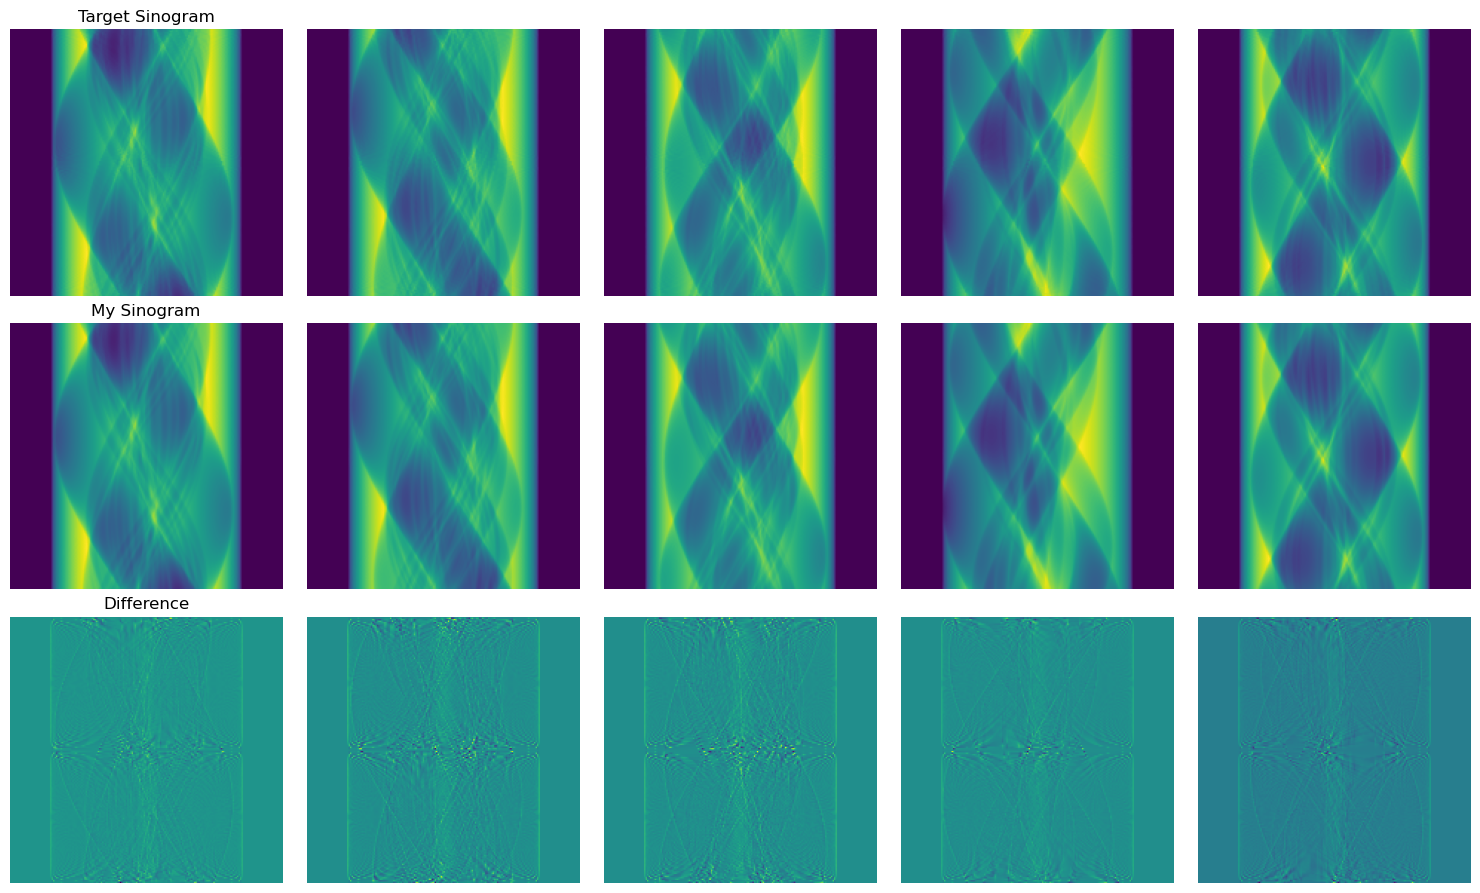

In [25]:
# Plot the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, target in enumerate(target_sinogram):
    axes[0, i].imshow(target.squeeze())
    axes[0, i].axis('off')

for i, sino in enumerate(my_sinogram):
    axes[1, i].imshow(sino.cpu().numpy())
    axes[1, i].axis('off')

# Calculate and plot the difference
for i in range(5):
    diff = torch.from_numpy(target_sinogram[i].squeeze()) - my_sinogram[i].cpu()
    axes[2, i].imshow(diff.cpu().numpy())
    axes[2, i].axis('off')

# Set titles for each row
axes[0, 0].set_title('Target Sinogram')
axes[1, 0].set_title('My Sinogram')
axes[2, 0].set_title('Difference')

plt.tight_layout()
plt.show()